In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
# Prediction libraries
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import plot_tree, export_text
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
#
import lasio
import segyio
import dask.array as da
import dask.dataframe as ddf
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Dict, List, Tuple, Callable

In [14]:
filepath = '‪E:\\Datasets\\reservior_simulation\\dataset\\F03-4_Attribute_Logs.csv'  # Your original path

# Clean the path by encoding to ASCII and decoding, ignoring errors.
cleaned_filepath = filepath.encode('ascii', 'ignore').decode('ascii')
print(f"Cleaned filepath: {cleaned_filepath}") 

df = pd.read_csv(cleaned_filepath)

Cleaned filepath: E:\Datasets\reservior_simulation\dataset\F03-4_Attribute_Logs.csv


In [15]:
df.head()

,Time,Porosity,Inst_Amp,Inst_Phase,Inst_Freq,Hilbert,Amp_2nd_Der,Cosine_Phase,Env_w_Phase,Env_w_Freq,Energy,Sqrt_Energy,Relief,F3_Velocity_Data,F3_Seismic_Data
0,0.000000,1.000000e+30,27.025831,1.570796,1.000000e+30,27.025831,1.000000e+30,0.000508,1.000000e+30,1.000000e+30,1.000000e+30,1.000000e+30,-43487.37109,1795.994263,0.0
1,0.355496,3.577000e-01,26.685862,1.570796,1.000000e+30,26.685862,1.000000e+30,-0.019956,1.000000e+30,1.000000e+30,1.000000e+30,1.000000e+30,-45077.98047,1795.994385,0.0
2,0.711000,3.576000e-01,26.390806,1.570796,1.000000e+30,26.390806,1.000000e+30,-0.045668,1.000000e+30,1.000000e+30,1.000000e+30,1.000000e+30,-46668.58594,1795.994385,0.0
3,1.066500,3.576000e-01,26.147465,1.570796,1.000000e+30,26.147465,1.000000e+30,-0.077058,1.000000e+30,1.000000e+30,1.000000e+30,1.000000e+30,-48259.21094,1795.994507,0.0
4,1.422004,3.576000e-01,25.962654,1.570796,1.000000e+30,25.962654,1.000000e+30,-0.114555,1.000000e+30,1.000000e+30,1.000000e+30,1.000000e+30,-49849.81641,1795.994629,0.0


# Data Rangling 

In [16]:
df[df==1.000000e+30] = np.nan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12466 entries, 0 to 12465
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Time              12466 non-null  float64
 1   Porosity          12197 non-null  float64
 2   Inst_Amp          12430 non-null  float64
 3   Inst_Phase        12430 non-null  float64
 4   Inst_Freq         12387 non-null  float64
 5   Hilbert           12460 non-null  float64
 6   Amp_2nd_Der       12362 non-null  float64
 7   Cosine_Phase      12460 non-null  float64
 8   Env_w_Phase       12417 non-null  float64
 9   Env_w_Freq        12377 non-null  float64
 10  Energy            12169 non-null  float64
 11  Sqrt_Energy       12169 non-null  float64
 12  Relief            12430 non-null  float64
 13  F3_Velocity_Data  12445 non-null  float64
 14  F3_Seismic_Data   12445 non-null  float64
dtypes: float64(15)
memory usage: 1.4 MB


In [17]:
# Zone of Interest data: from 500 to 1100ms
df_inter = df[(df.Time >= 500) & (df.Time <= 1100)]
df_inter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4399 entries, 3117 to 7515
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Time              4399 non-null   float64
 1   Porosity          4399 non-null   float64
 2   Inst_Amp          4399 non-null   float64
 3   Inst_Phase        4399 non-null   float64
 4   Inst_Freq         4399 non-null   float64
 5   Hilbert           4399 non-null   float64
 6   Amp_2nd_Der       4399 non-null   float64
 7   Cosine_Phase      4399 non-null   float64
 8   Env_w_Phase       4399 non-null   float64
 9   Env_w_Freq        4399 non-null   float64
 10  Energy            4399 non-null   float64
 11  Sqrt_Energy       4399 non-null   float64
 12  Relief            4399 non-null   float64
 13  F3_Velocity_Data  4399 non-null   float64
 14  F3_Seismic_Data   4399 non-null   float64
dtypes: float64(15)
memory usage: 549.9 KB


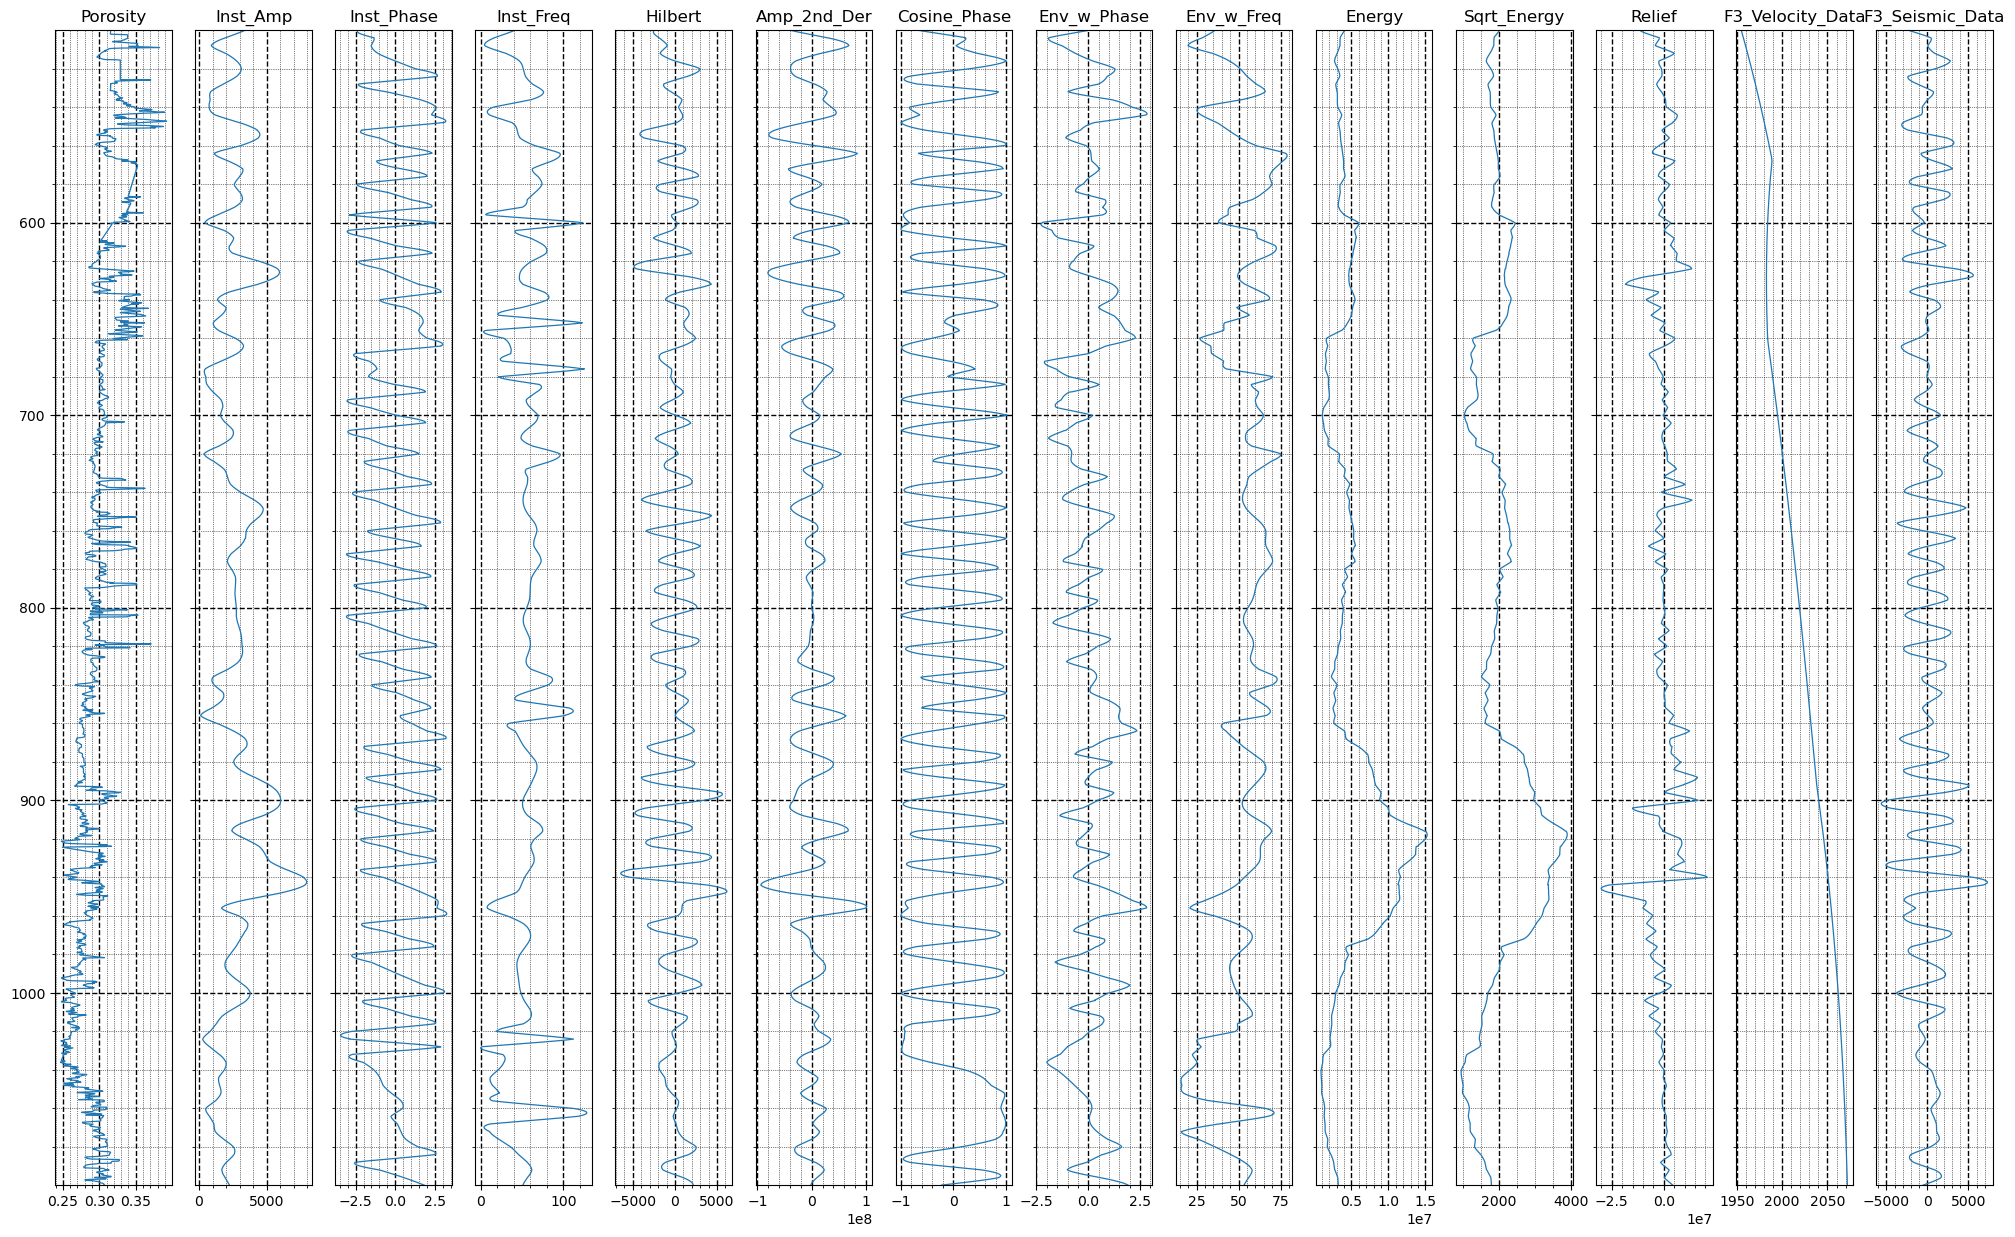

In [18]:
# Plot the inputs
rows, cols = 1,len(df_inter.columns)-1
fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize=(25,15), sharey=True)
names = [ 'Time', 'Porosity', 'Inst_Amp', 'Inst_Phase', 'Inst_Freq', 'Hilbert',
       'Amp_2nd_Der', 'Cosine_Phase', 'Env_w_Phase', 'Env_w_Freq', 'Energy', 'Sqrt_Energy', 'Relief', 'F3_Velocity_Data', 'F3_Seismic_Data']
for i in range(cols):
    ax[i].plot(df_inter.iloc[:,i+1], df_inter.iloc[:,0],linewidth='0.9')
    ax[i].set_ylim(max(df_inter.iloc[:, 0]), min(df_inter.iloc[:, 0]))
    ax[i].minorticks_on()
    ax[i].grid(which='major', linestyle='dashed', linewidth='1', color='black')
    ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax[i].set_title('%s' %names[i+1])

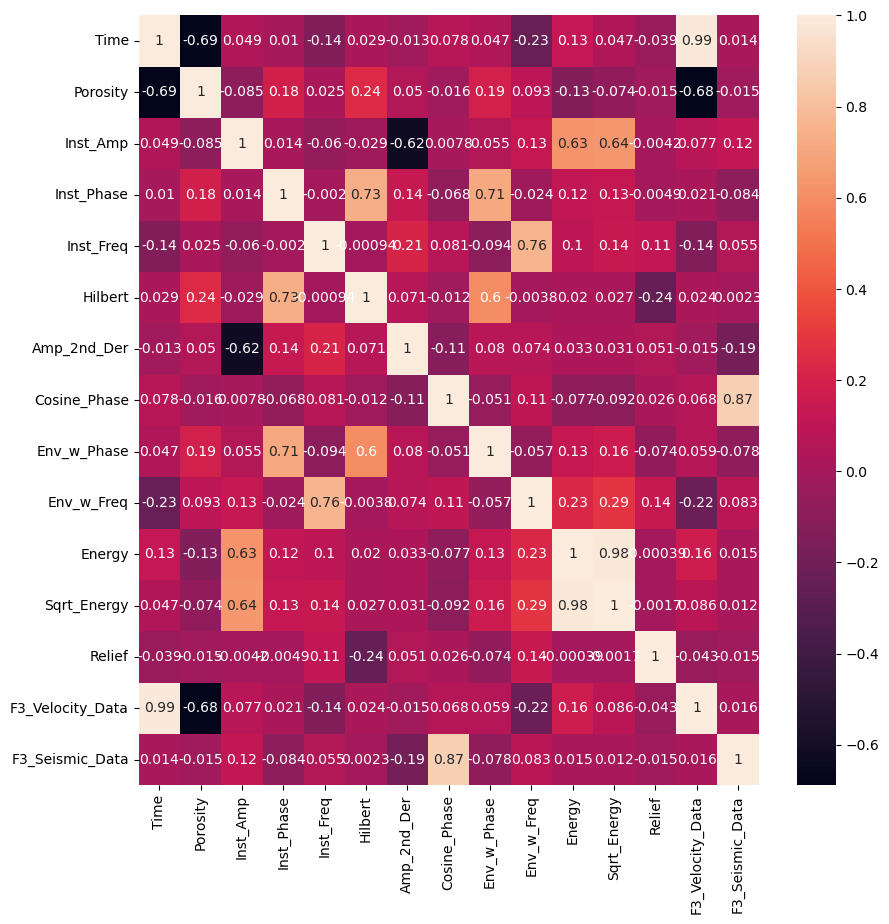

In [19]:
plt.figure(figsize = (10,10))
sns.heatmap(df_inter.corr(),annot = True)
plt.show()

In [21]:
# Define dataset and Prediction

Xdata = df_inter[['Inst_Amp', 'Inst_Phase', 'Inst_Freq', 'Hilbert',
       'Amp_2nd_Der', 'Cosine_Phase', 'Env_w_Phase', 'Env_w_Freq', 'Energy', 'Relief', 'F3_Velocity_Data', 'F3_Seismic_Data']]
ydata = df_inter['Porosity']

print("shape of Xdata: ",Xdata.shape)
print("shape of Ydata: ",ydata.shape)

shape of Xdata:  (4399, 12)
shape of Ydata:  (4399,)


In [22]:
scaler = StandardScaler()
# transform dataset 
data_scal = scaler.fit_transform(Xdata)
x_trans_data = pd.DataFrame(data_scal,columns = Xdata.columns)
x_trans_data

,Inst_Amp,Inst_Phase,Inst_Freq,Hilbert,Amp_2nd_Der,Cosine_Phase,Env_w_Phase,Env_w_Freq,Energy,Relief,F3_Velocity_Data,F3_Seismic_Data
0,0.564885,-1.479120,-0.585778,-1.222474,-1.313781,-1.047847,0.033318,-1.140809,-0.127261,-2.021990,-1.967904,-1.206885
1,0.534829,-1.498070,-0.616775,-1.236330,-1.249569,-1.000989,-0.038753,-1.157224,-0.135014,-1.999255,-1.965396,-1.156322
2,0.503883,-1.512330,-0.649138,-1.247668,-1.182938,-0.953011,-0.112160,-1.173967,-0.142825,-1.971496,-1.962887,-1.104939
3,0.472095,-1.522105,-0.682787,-1.256570,-1.114024,-0.904029,-0.186737,-1.191026,-0.150685,-1.938987,-1.960382,-1.052839
4,0.439514,-1.527595,-0.717646,-1.263122,-1.042965,-0.854155,-0.262315,-1.208393,-0.158583,-1.902001,-1.957881,-1.000123
...,...,...,...,...,...,...,...,...,...,...,...,...
4394,-0.275102,0.961659,-0.121018,1.080901,-0.039593,-0.092414,1.763705,0.091322,-0.413578,0.684247,1.499971,-0.095844
4395,-0.267778,0.988111,-0.127529,1.086819,-0.047068,-0.156876,1.792143,0.085697,-0.412949,0.707805,1.500195,-0.141124
4396,-0.260548,1.014535,-0.133722,1.091026,-0.053901,-0.221136,1.818206,0.080239,-0.412278,0.730420,1.500419,-0.186450
4397,-0.253433,1.040878,-0.139573,1.093475,-0.060058,-0.284944,1.841760,0.074970,-0.411561,0.751951,1.500644,-0.231650


In [23]:
X_train, X_test, y_train, y_test = train_test_split(x_trans_data, ydata, test_size=0.25)

RFR =RandomForestRegressor()
RFR.fit(X_train,y_train)
Ypred = RFR.predict(X_test)
RFR.score(X_test, y_test) * 100

97.82221710602934

# Feature Importance

In [24]:
feature_imp = pd.Series(RFR.feature_importances_,index=Xdata.columns).sort_values(ascending=False)
feature_imp

F3_Velocity_Data    0.678528
Hilbert             0.052494
Energy              0.052361
Relief              0.038684
Env_w_Phase         0.034408
Inst_Amp            0.028868
F3_Seismic_Data     0.023622
Env_w_Freq          0.023488
Inst_Phase          0.019843
Amp_2nd_Der         0.017343
Cosine_Phase        0.015639
Inst_Freq           0.014721
dtype: float64

In [38]:
data_featured = x_trans_data[['F3_Velocity_Data', 'Energy', 'Hilbert', 'Relief', 'Env_w_Phase','Inst_Amp']]
data_featured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4399 entries, 0 to 4398
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   F3_Velocity_Data  4399 non-null   float64
 1   Energy            4399 non-null   float64
 2   Hilbert           4399 non-null   float64
 3   Relief            4399 non-null   float64
 4   Env_w_Phase       4399 non-null   float64
 5   Inst_Amp          4399 non-null   float64
dtypes: float64(6)
memory usage: 206.3 KB


In [39]:
X_train, X_test, y_train, y_test = train_test_split(data_featured, ydata, test_size=0.25)

# Model Selection: 

## 1. Linear Regression

In [40]:
linear_rg = LinearRegression()
linear_rg.fit(X_train, y_train)

pred_linear_rg_train = linear_rg.predict(X_train)
pred_linear_rg_test = linear_rg.predict(X_test)
pred_linear_rg = linear_rg.predict(data_featured)

# Print the RMS Error and Score
print('RMSE for training data = ', round(mean_squared_error(y_train, pred_linear_rg_train), 4))
print('R2 Score for training data = ', round(r2_score(y_train, pred_linear_rg_train), 2))

print('RMSE for testing data = ', round(mean_squared_error(y_test, pred_linear_rg_test), 4))
print('R2 Score for testing data = ', round(r2_score(y_test, pred_linear_rg_test), 2))

RMSE for training data =  0.0003
R2 Score for training data =  0.54
RMSE for testing data =  0.0003
R2 Score for testing data =  0.56


## 2. Random Forest



In [41]:
RFR =RandomForestRegressor(random_state=42, max_depth=10)
RFR.fit(X_train,y_train)
# Estimate Predictions
pred_RFR_train= RFR.predict(X_train)
pred_RFR_test=RFR.predict(X_test)
pred_RFR = RFR.predict(data_featured)
# Print the RMS Error and Score
print('RMSE for training data = ', round(mean_squared_error(y_train,pred_RFR_train), 4))
print('R2 Score for training data = ', round(r2_score(y_train, pred_RFR_train), 2))
print('RMSE for testing data = ', round(mean_squared_error(y_test,pred_RFR_test), 4))
print('R2 Score for testing data = ', round(r2_score(y_test, pred_RFR_test), 2))

RMSE for training data =  0.0
R2 Score for training data =  0.98
RMSE for testing data =  0.0
R2 Score for testing data =  0.96


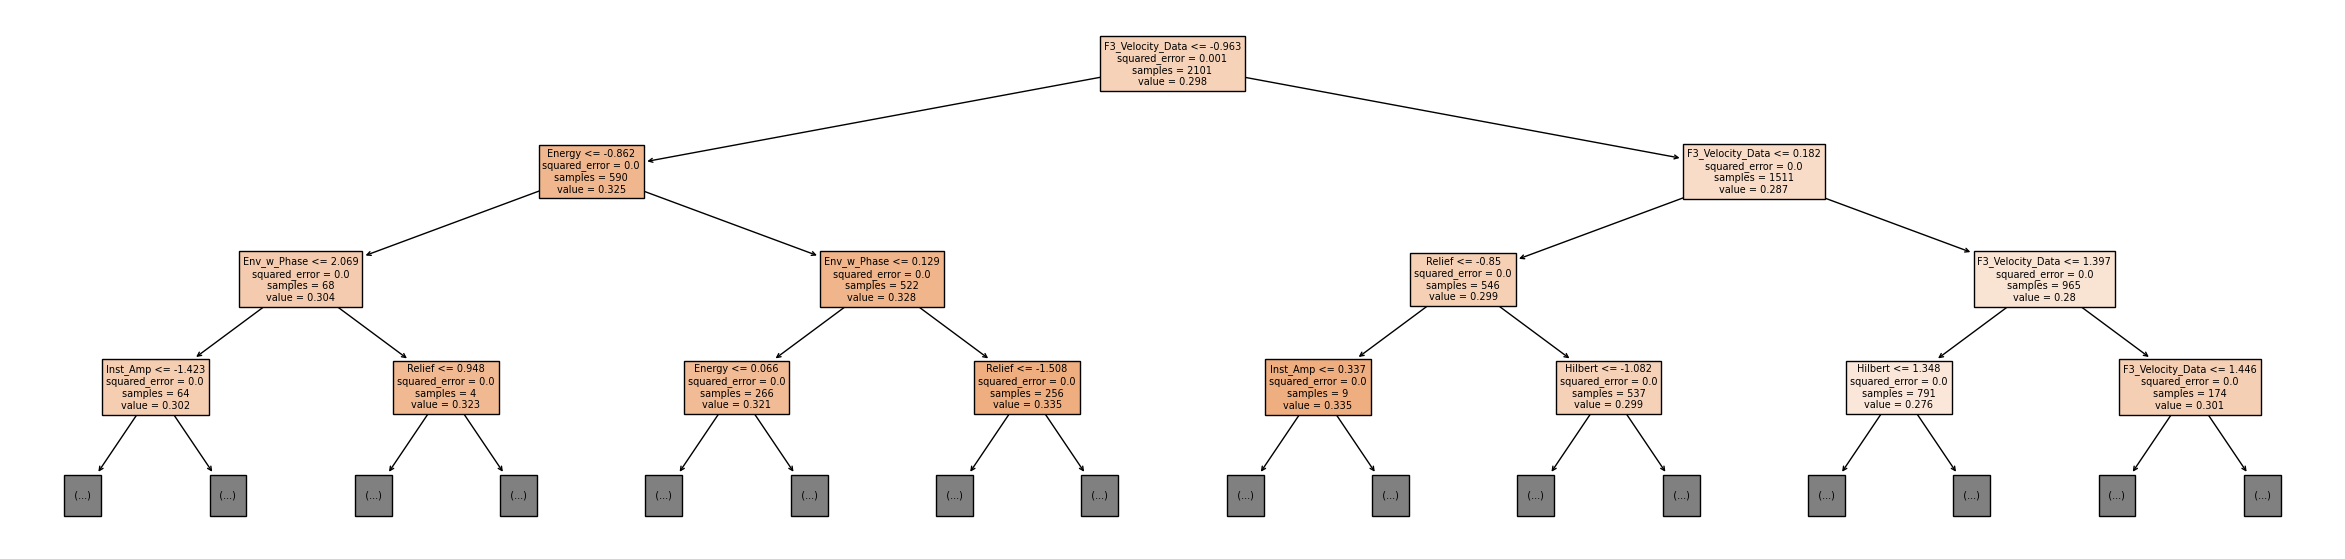

In [42]:
# Visualize the Forest
plt.figure(figsize=(30,7))
plot_tree(RFR.estimators_[20], max_depth=3, feature_names=X_train.columns, filled=True, rounded=False);

## 3. Nerual Network


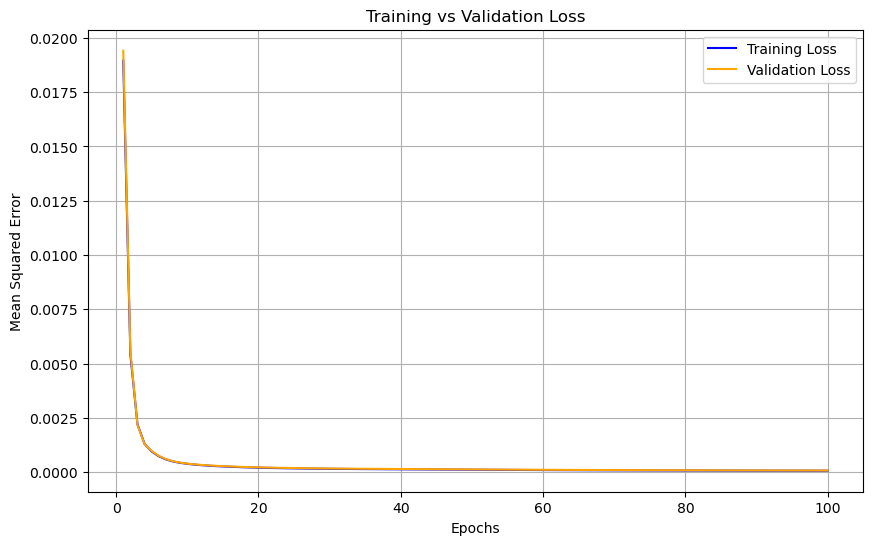

In [43]:
model_NN = MLPRegressor(hidden_layer_sizes=(50, 50, 50),      # Two hidden layers with 50 neurons each
                     activation='relu',                       # Activation function
                     solver='adam',                           # Optimizer
                     max_iter=100,                            # Number of epochs
                     random_state=42)

# Step 2: Train the model and track training and validation loss
train_loss = []
val_loss = []

for epoch in range(model_NN.max_iter):
    model_NN.partial_fit(X_train, y_train)  # Fit one epoch
    
    pred_xtrain = model_NN.predict(X_train)
    pred_xtest = model_NN.predict(X_test)

    MSE_T = mean_squared_error(y_train, pred_xtrain)  # Training loss
    MSE_V = mean_squared_error(y_test, pred_xtest)    # Validation loss
    
    train_loss.append(MSE_T)    
    val_loss.append(MSE_V)       
    
# Step 3: Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, model_NN.max_iter + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, model_NN.max_iter + 1), val_loss, label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid()
plt.show()

In [44]:
# Estimate Predictions
pred_model_NN_train= model_NN.predict(X_train)
pred_model_NN_test=model_NN.predict(X_test)
pred_model_NN = model_NN.predict(data_featured)

# Print the RMS Error and Score
#TRAIN
print('RMSE for training data = ', round(mean_squared_error(y_train,pred_model_NN_train), 4))
print('R2 Score for training data = ', round(r2_score(y_train, pred_model_NN_train), 2))
#TEST
print('RMSE for testing data = ', round(mean_squared_error(y_test,pred_model_NN_test), 4))
print('R2 Score for testing data = ', round(r2_score(y_test, pred_model_NN_test), 2))

RMSE for training data =  0.0001
R2 Score for training data =  0.9
RMSE for testing data =  0.0001
R2 Score for testing data =  0.89


In [48]:
# Add the prediction columns to the DataFrame 'df'
df_inter['pred_L_reg'] = pred_linear_rg
df_inter['pred_RFR'] = pred_RFR
df_inter['pred_NN'] = pred_model_NN


# the prediction DataFrame
prediction_df = df_inter[['Time','Porosity','pred_L_reg','pred_RFR','pred_NN']]
prediction_df

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_21576\164065211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inter['pred_L_reg'] = pred_linear_rg
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_21576\164065211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inter['pred_RFR'] = pred_RFR
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_21576\164065211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

,Time,Porosity,pred_L_reg,pred_RFR,pred_NN
3117,500.057220,0.3155,0.326127,0.314949,0.317629
3118,500.198792,0.3155,0.325823,0.315380,0.318093
3119,500.340393,0.3154,0.325529,0.315504,0.319827
3120,500.482025,0.3154,0.325245,0.315463,0.317871
3121,500.623596,0.3154,0.324971,0.316818,0.315968
...,...,...,...,...,...
7511,1099.338135,0.3064,0.283162,0.306301,0.304021
7512,1099.474487,0.3067,0.283279,0.306445,0.305120
7513,1099.610718,0.3069,0.283381,0.306457,0.306158
7514,1099.746826,0.3067,0.283466,0.306369,0.306553


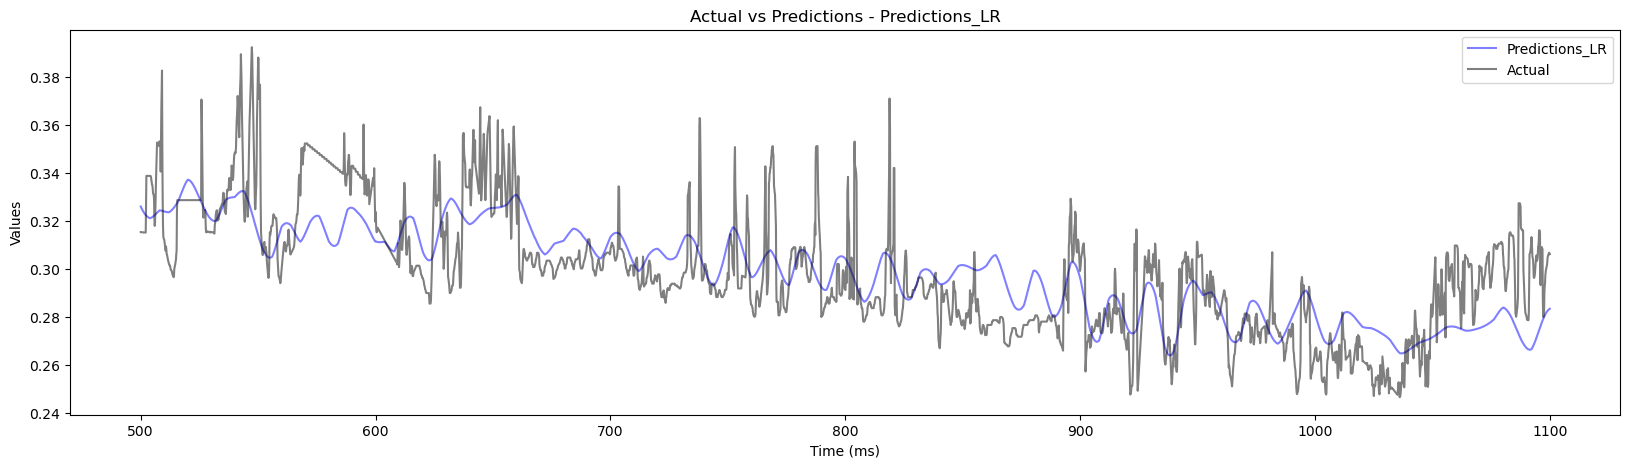

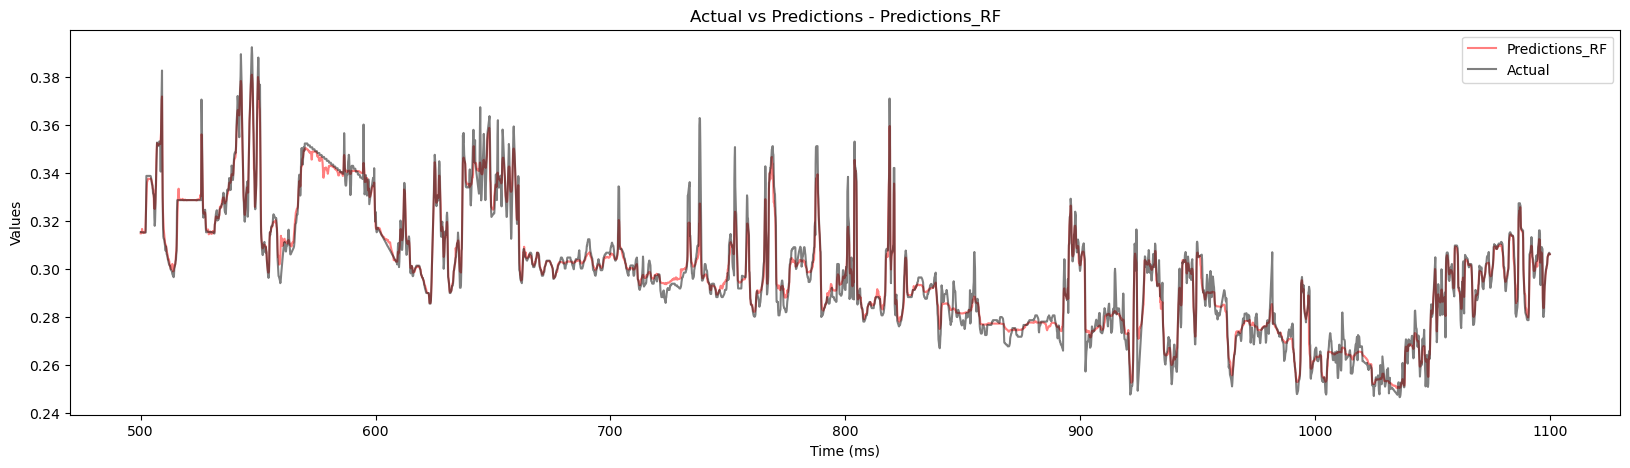

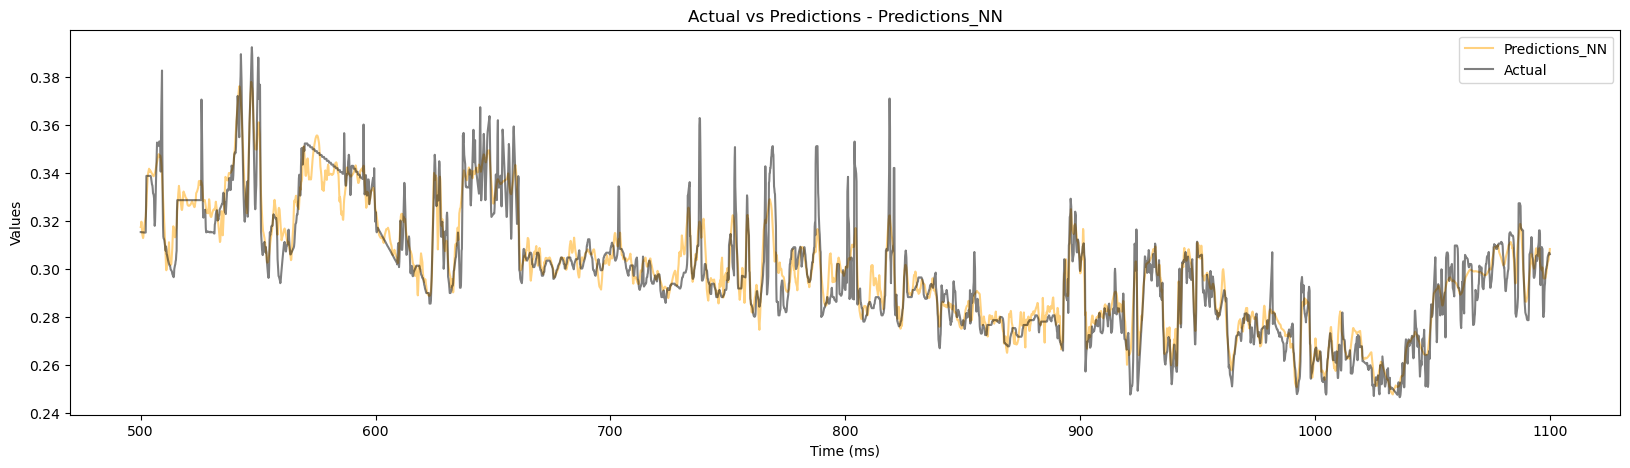

In [49]:
# Define a list of models and their respective colors and labels
models = [
    ('pred_L_reg', 'blue', 'Predictions_LR'),
    ('pred_RFR', 'red', 'Predictions_RF'),
    ('pred_NN', 'orange', 'Predictions_NN'),
]

# Actual values
actual = prediction_df['Porosity']
depth = prediction_df['Time']

# Create separate plots for each model
for model, color, label in models:
    plt.figure(figsize=(20, 5))
    plt.plot(depth, prediction_df[model], c=color, alpha=0.5, label=label)
    plt.plot(depth, actual, c='black', alpha=0.5, label='Actual')

    # Labels and title
    plt.xlabel("Time (ms)")
    plt.ylabel("Values")
    plt.title(f"Actual vs Predictions - {label}")
    plt.legend()

    # Show the plot
    plt.show()

In [50]:
#@title Save the Trained Models
import joblib
# Save the models to a file
joblib.dump(linear_rg, r'E:\Datasets\reservior_simulation\models\linear_regression_model.pkl')
joblib.dump(RFR, r'E:\Datasets\reservior_simulation\models\random_forest_model.pkl')
joblib.dump(model_NN, r'E:\Datasets\reservior_simulation\models\neural_network_model.pkl')
print("Models saved successfully!")

Models saved successfully!
